#### Instalando as bibliotecas necessárias

#### Importando as bibliotecas

In [63]:
# Importando tudo que a análise econometrica precisa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [64]:
# importando dados de uma planilha do google sheets por link
# https://docs.google.com/spreadsheets/d/1kn6u7jnv-ktwiY0TMYxYWnQhr54dWOYSOYvrqf9W3WY/edit?usp=sharing

url = 'https://docs.google.com/spreadsheets/d/1kn6u7jnv-ktwiY0TMYxYWnQhr54dWOYSOYvrqf9W3WY/export?format=csv'
df = pd.read_csv(url)

df

,Carimbo de data/hora,"Ao clicar em ""Aceito"", você declara que compreendeu as informações e consente em participar.",Qual seu nível de formação em Ciências Econômicas?,Você é homem?,Com qual grupo racial/étnico você mais se identifica?,Qual seu nível de escolaridade?,Qual é a sua faixa etária?,Em qual região do Brasil você reside?,Qual é o seu vínculo empregatício?,"Você trabalha com economia, finanças, contabilidade ou áreas correlatas?",...,O governo atual sabe lidar com crises econômicas,O governo deve intervir para controlar preços,A entrada de estrangeiros no mercado de trabalho é benéfica,A indústria nacional deve ser protegida,O Brasil tem chance de virar potência econômica,Lucros empresariais ocorrem às custas dos trabalhadores,A competição entre empresas beneficia consumidores,O Brasil deveria priorizar a produção interna mesmo com preços maiores,A automação prejudica o mercado de trabalho,O Brasil deveria adotar política de livre comércio com outros países
0,01/08/2025 09:24:09,Aceito participar,Não tenho formação em Economia,Sim,Branco,Ensino Superior Completo,19 a 25 anos,Sul,Empregado com carteira assinada (CLT),Sim,...,(0) Discorda,(1) Parcialmente concorda,(2) Concorda,(1) Parcialmente concorda,(2) Concorda,(1) Parcialmente concorda,(2) Concorda,(0) Discorda,(2) Concorda,(2) Concorda
1,01/08/2025 09:30:26,Aceito participar,Graduação em Economia,Não,Branco,Ensino Superior Incompleto,19 a 25 anos,Sul,Estudante,Não,...,(0) Discorda,(0) Discorda,(1) Parcialmente concorda,(2) Concorda,(2) Concorda,(2) Concorda,(2) Concorda,(1) Parcialmente concorda,(1) Parcialmente concorda,(2) Concorda
2,01/08/2025 09:32:26,Aceito participar,Não tenho formação em Economia,Sim,Branco,Ensino Superior Incompleto,19 a 25 anos,Sul,Empregado sem carteira assinada,Não,...,(0) Discorda,(1) Parcialmente concorda,(2) Concorda,(2) Concorda,(0) Discorda,(0) Discorda,(2) Concorda,(1) Parcialmente concorda,(2) Concorda,(2) Concorda
3,01/08/2025 09:33:14,Aceito participar,Não tenho formação em Economia,Sim,Negro,Ensino Superior Completo,26 a 35 anos,Sudeste,Empregado com carteira assinada (CLT),Não,...,(2) Concorda,(2) Concorda,(2) Concorda,(2) Concorda,(2) Concorda,(2) Concorda,(1) Parcialmente concorda,(2) Concorda,(2) Concorda,(1) Parcialmente concorda
4,01/08/2025 09:39:04,Aceito participar,Não tenho formação em Economia,Sim,Branco,Ensino Superior Completo,26 a 35 anos,Sul,Empregado com carteira assinada (CLT),Não,...,(0) Discorda,(0) Discorda,(2) Concorda,(1) Parcialmente concorda,(2) Concorda,(1) Parcialmente concorda,(2) Concorda,(1) Parcialmente concorda,(1) Parcialmente concorda,(1) Parcialmente concorda
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,04/08/2025 18:11:41,Aceito participar,Graduação em Economia,Sim,Branco,Pós-graduação,26 a 35 anos,Sul,Outro,Não,...,(0) Discorda,(0) Discorda,(2) Concorda,(0) Discorda,(1) Parcialmente concorda,(0) Discorda,(2) Concorda,(0) Discorda,(0) Discorda,(2) Concorda
142,04/08/2025 19:20:29,Aceito participar,Graduação em Economia,Sim,Branco,Ensino Superior Completo,19 a 25 anos,Sul,Empresário,Sim,...,(2) Concorda,(0) Discorda,(2) Concorda,(0) Discorda,(2) Concorda,(0) Discorda,(2) Concorda,(0) Discorda,(0) Discorda,(2) Concorda
143,04/08/2025 19:27:17,Aceito participar,Mestrado em Economia,Não,Branco,Pós-graduação,36 a 45 anos,Sul,Empregado com carteira assinada (CLT),Sim,...,(0) Discorda,(1) Parcialmente concorda,(1) Parcialmente concorda,(1) Parcialmente concorda,(1) Parcialmente concorda,(1) Parcialmente concorda,(2) Concorda,(1) Parcialmente concorda,(0) Discorda,(1) Parcialmente concorda
144,04/08/2025 20:25:58,Aceito participar,Graduação em Economia,Não,Branco,Ensino Médio Completo,19 a 25 anos,Sul,Autônomo,Não,...,(0) Discorda,(2) Concorda,(0) Discorda,(2) Concorda,(0) Discorda,(2) Concorda,(2) Concorda,(2) Concorda,(1) Parcialmente concorda,(1) Parcialmente concorda


In [97]:
# vazio
df_coded = pd.DataFrame()

In [98]:
df_coded['nivel_formacao_economia'] = df['Qual seu nível de formação em Ciências Econômicas? '].map({
    'Não tenho formação em Economia': 0,
    'Graduação em Economia': 1,
    'Mestrado em Economia': 2,
    'Doutorado em Economia': 3
})

df_coded['nivel_formacao_economia'].unique()

array([0, 1, 3, 2])

In [99]:
df_coded['econ'] = (df_coded['nivel_formacao_economia'] > 1).astype(int)

df_coded['econ'].unique()

array([0, 1])

In [100]:
df_coded['masculino'] = df['Você é homem? '].map({
    'Sim': 1,
    'Não': 0
})

df_coded['masculino'].unique()

array([1, 0])

In [101]:
df_coded['raca'] = df['Com qual grupo racial/étnico você mais se identifica? '].map({
    'Branco': 1,
    'Negro': 2,
    'Asiático': 3,
    'Outro': 4
})

df_coded['raca'].unique()

array([1, 2, 4, 3])

In [102]:
df_coded['escolaridade'] = df['Qual seu nível de escolaridade? '].map({
    'Ensino Fundamental Incompleto': 0,
    'Ensino Fundamental Completo': 1,
    'Ensino Médio Incompleto': 2,
    'Ensino Médio Completo': 3,
    'Ensino Superior Incompleto': 4,
    'Ensino Superior Completo': 5,
    'Pós-graduação': 6
})

df_coded['escolaridade'].unique()

array([5, 4, 2, 6, 3, 1])

In [103]:
df_coded['faixa_etaria'] = df['Qual é a sua faixa etária? '].map({
    'Até 18 anos': 1,
    '19 a 25 anos': 2,
    '26 a 35 anos': 3,
    '36 a 45 anos': 4,
    '46 a 55 anos': 5,
    '56 a 65 anos': 6,
    '66 anos ou mais': 7
})

df_coded['faixa_etaria'].unique()

array([2, 3, 4, 1, 6, 5, 7])

In [104]:
df_coded['regiao'] = df['Em qual região do Brasil você reside? '].map({
    'Norte': 1,
    'Nordeste': 2,
    'Centro-Oeste': 3,
    'Sudeste': 4,
    'Sul': 5
})

df_coded['regiao'].unique()

array([5, 4, 1, 3, 2])

In [105]:
df_coded['vinculo_emprego'] = df['Qual é o seu vínculo empregatício? '].map({
    'Empregado com carteira assinada (CLT)': 1,
    'Empregado sem carteira assinada': 2,
    'Autônomo': 3,
    'Empresário': 4,
    'Desempregado': 5,
    'Estudante': 6,
    'Aposentado': 7,
    'Servidor público': 8,
    'Outro': 9
})

df_coded['vinculo_emprego'].unique()

array([1, 6, 2, 9, 4, 8, 7, 3, 5])

In [74]:
df_coded['trabalha_area_economia'] = df['Você trabalha com economia, finanças, contabilidade ou áreas correlatas? '].map({
    'Sim': 1,
    'Não': 0
})

In [75]:
df_coded['trabalha_area_politica'] = df['Você trabalha com política ou áreas correlatas? '].map({
    'Sim': 1,
    'Não': 0
})

In [76]:
df_coded['engajamento_politico'] = df['Você se considera uma pessoa politicamente engajada? '].map({
    'Sim': 1,
    'Não': 0
})

In [77]:
df_coded['acompanha_noticias'] = df['Você costuma acompanhar notícias sobre economia e política? '].map({
    'Sim': 1,
    'Não': 0
})

In [78]:
df_coded['espectro_politico'] = df['Com qual espectro político você mais se identifica? '].map({
    'Extrema esquerda': 1,
    'Esquerda': 2,
    'Centro': 3,
    'Direita': 4,
    'Extrema direita': 5,
    'Independente': 6,
    'Sem opinião': 7
})

In [79]:
df_coded

,nivel_formacao_economia,econ,masculino,raca,escolaridade,faixa_etaria,regiao,vinculo_emprego,trabalha_area_economia,trabalha_area_politica,engajamento_politico,acompanha_noticias,espectro_politico
0,0,0,1,1,5,2,5,1,1,0,1,1,6
1,1,0,0,1,4,2,5,6,0,0,0,1,3
2,0,0,1,1,4,2,5,2,0,0,0,1,4
3,0,0,1,2,5,3,4,1,0,0,1,1,2
4,0,0,1,1,5,3,5,1,0,0,0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,1,0,1,1,6,3,5,9,0,0,1,1,4
142,1,0,1,1,5,2,5,4,1,0,1,1,4
143,2,0,0,1,6,4,5,1,1,0,0,1,6
144,1,0,0,1,3,2,5,3,0,0,1,1,2


### Perguntas

In [80]:
import re

def detect_number(row):
    # Se for NaN, retorna np.nan
    if pd.isnull(row):
        return np.nan
    # Busca todos os dígitos
    matches = re.findall(r'[0-9]', str(row))
    if matches:
        # Converte para inteiro e pega o menor valor (prioridade: menor número)
        return min(map(int, matches))
    else:
        return np.nan

In [81]:
df_loop = pd.DataFrame()

# perguntas que não vão entrar no loop
lista = ['Carimbo de data/hora'
         , 'Ao clicar em "Aceito", você declara que compreendeu as informações e consente em participar.',
         'Qual seu nível de formação em Ciências Econômicas? ', 'Você é homem? ',
         'Com qual grupo racial/étnico você mais se identifica? ', 'Qual seu nível de escolaridade? ',
         'Qual é a sua faixa etária? ', 'Em qual região do Brasil você reside? ',
         'Qual é o seu vínculo empregatício? ', 'Você trabalha com economia, finanças, contabilidade ou áreas correlatas? ',
         'Você trabalha com política ou áreas correlatas? ',
         'Você se considera uma pessoa politicamente engajada? ',
         'Você costuma acompanhar notícias sobre economia e política? ',
         'Com qual espectro político você mais se identifica? ']

for col in df.columns:
    # Ignora colunas que não estão na lista
    if col in lista:
        continue
    # Você pode filtrar colunas aqui se não quiser mapear todas!
    df_loop[col + '_map'] = df[col].apply(detect_number)

# Exemplo visualização:
df_loop

,Os impostos são muito altos_map,O déficit federal é grande demais (Dívida pública)_map,O gasto com ajuda externa é alto demais_map,Temos imigrantes demais_map,Há deduções demais para as empresas (Impostos)_map,A educação e a qualificação profissional são inadequadas_map,A seguridade social (Previdência) atende pessoas demais_map,Mulheres e minorias têm vantagens demais por causa das ações afirmativas (cotas)_map,As pessoas não dão valor ao trabalho duro_map,O governo regulamenta muito os negócios_map,...,O governo atual sabe lidar com crises econômicas_map,O governo deve intervir para controlar preços_map,A entrada de estrangeiros no mercado de trabalho é benéfica_map,A indústria nacional deve ser protegida_map,O Brasil tem chance de virar potência econômica_map,Lucros empresariais ocorrem às custas dos trabalhadores_map,A competição entre empresas beneficia consumidores_map,O Brasil deveria priorizar a produção interna mesmo com preços maiores_map,A automação prejudica o mercado de trabalho_map,O Brasil deveria adotar política de livre comércio com outros países_map
0,2,1.0,1.0,0.0,2,1.0,1,0.0,0,2,...,0.0,1.0,2.0,1.0,2.0,1.0,2.0,0.0,2.0,2.0
1,2,2.0,1.0,0.0,1,2.0,0,1.0,1,1,...,0.0,0.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0
2,1,1.0,1.0,0.0,1,2.0,1,0.0,1,1,...,0.0,1.0,2.0,2.0,0.0,0.0,2.0,1.0,2.0,2.0
3,1,1.0,1.0,0.0,2,1.0,1,0.0,0,0,...,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0
4,2,2.0,0.0,0.0,0,1.0,0,1.0,1,0,...,0.0,0.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,2,2.0,0.0,0.0,0,1.0,1,2.0,0,2,...,0.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0
142,2,2.0,0.0,0.0,2,2.0,1,0.0,0,0,...,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0
143,1,2.0,0.0,0.0,1,2.0,1,0.0,0,1,...,0.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0
144,2,1.0,2.0,0.0,0,1.0,1,0.0,0,0,...,0.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,1.0,1.0


In [82]:
# Função para gerar acrônimos
def make_acronym(colname):
    col = colname
    # Remove _map do final
    col = re.sub(r'_map$', '', col)
    # Substitui caracteres especiais/acentos por espaço
    col = re.sub(r'[^\w\s]', ' ', col, flags=re.UNICODE)
    # Remove palavras muito comuns que poluem acrônimos
    stopwords = {
        'de', 'da', 'do', 'das', 'dos', 'a', 'o', 'as', 'os',
        'em', 'na', 'no', 'nas', 'nos', 'para', 'por', 'com',
        'ao', 'à', 'às', 'e', 'ou', 'que', 'se', 'é', 'uma',
        'você', 'qual', 'sua', 'são', 'sobre', 'tem', 'temos',
        'está', 'foi', 'ser', 'vai', 'mais', 'menos', 'muito',
        'pouco', 'muita', 'alguma', 'algumas', 'alguns', 'todo',
        'toda', 'todos', 'todas', 'meio', 'meia', 'nenhum', 'nenhuma'
    }
    tokens = [t.lower() for t in col.split() if t.lower() not in stopwords]
    # Pega só as primeiras 3-4 palavras ou sigla das principais palavras
    if len(tokens) >= 2:
        acro = '_'.join(tokens[:3])
    else:
        acro = tokens[0] if tokens else col.lower()
    # Só letras e _
    acro = re.sub(r'[^a-zA-Z0-9_]', '', acro)
    return acro

# Use lista as map_cols
map_cols = df_loop.columns.tolist()

# Dicionário para renomear: coluna original → acrônimo
rename_dict = {c: make_acronym(c) for c in map_cols}

# Novo DataFrame somente com as colunas mapeadas e renomeadas
df_mapped = df_loop[map_cols].rename(columns=rename_dict)

# criando um dicionário para poder encontrar as colunas mapeadas, com a pergunta original e após a aplicação do acrônimo
# Exemplo: {'nivel_formacao_economia_map': 'nfe', ...}
rename_dict = {c: make_acronym(c) for c in map_cols}

# Exemplo: visualize as primeiras linhas e os nomes finais das colunas
df_mapped


,impostos_altos,dficit_federal_grande,gasto_ajuda_externa,imigrantes_demais,h_dedues_demais,educao_qualificao_profissional,seguridade_social_previdncia,mulheres_minorias_tm,pessoas_no_do,governo_regulamenta_negcios,...,governo_atual_sabe,governo_deve_intervir,entrada_estrangeiros_mercado,indstria_nacional_deve,brasil_chance_virar,lucros_empresariais_ocorrem,competio_entre_empresas,brasil_deveria_priorizar,automao_prejudica_mercado,brasil_deveria_adotar
0,2,1.0,1.0,0.0,2,1.0,1,0.0,0,2,...,0.0,1.0,2.0,1.0,2.0,1.0,2.0,0.0,2.0,2.0
1,2,2.0,1.0,0.0,1,2.0,0,1.0,1,1,...,0.0,0.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0
2,1,1.0,1.0,0.0,1,2.0,1,0.0,1,1,...,0.0,1.0,2.0,2.0,0.0,0.0,2.0,1.0,2.0,2.0
3,1,1.0,1.0,0.0,2,1.0,1,0.0,0,0,...,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0
4,2,2.0,0.0,0.0,0,1.0,0,1.0,1,0,...,0.0,0.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,2,2.0,0.0,0.0,0,1.0,1,2.0,0,2,...,0.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0
142,2,2.0,0.0,0.0,2,2.0,1,0.0,0,0,...,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0
143,1,2.0,0.0,0.0,1,2.0,1,0.0,0,1,...,0.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0
144,2,1.0,2.0,0.0,0,1.0,1,0.0,0,0,...,0.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,1.0,1.0


In [83]:
# Juntando os dois DataFrames
df_final = pd.concat([df_coded, df_mapped], axis=1)

df_final

,nivel_formacao_economia,econ,masculino,raca,escolaridade,faixa_etaria,regiao,vinculo_emprego,trabalha_area_economia,trabalha_area_politica,...,governo_atual_sabe,governo_deve_intervir,entrada_estrangeiros_mercado,indstria_nacional_deve,brasil_chance_virar,lucros_empresariais_ocorrem,competio_entre_empresas,brasil_deveria_priorizar,automao_prejudica_mercado,brasil_deveria_adotar
0,0,0,1,1,5,2,5,1,1,0,...,0.0,1.0,2.0,1.0,2.0,1.0,2.0,0.0,2.0,2.0
1,1,0,0,1,4,2,5,6,0,0,...,0.0,0.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0
2,0,0,1,1,4,2,5,2,0,0,...,0.0,1.0,2.0,2.0,0.0,0.0,2.0,1.0,2.0,2.0
3,0,0,1,2,5,3,4,1,0,0,...,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0
4,0,0,1,1,5,3,5,1,0,0,...,0.0,0.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,1,0,1,1,6,3,5,9,0,0,...,0.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0
142,1,0,1,1,5,2,5,4,1,0,...,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0
143,2,0,0,1,6,4,5,1,1,0,...,0.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0
144,1,0,0,1,3,2,5,3,0,0,...,0.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,1.0,1.0


In [84]:
# invertendo o dicionário para poder encontrar as colunas mapeadas, com a pergunta original e após a aplicação do acrônimo
# Exemplo: {'nfe': 'nivel_formacao_economia_map', ...}
rename_dict = {v: k for k, v in rename_dict.items()}
rename_dict

{'impostos_altos': 'Os impostos são muito altos_map',
 'dficit_federal_grande': 'O déficit federal é grande demais (Dívida pública)_map',
 'gasto_ajuda_externa': 'O gasto com ajuda externa é alto demais_map',
 'imigrantes_demais': 'Temos imigrantes demais_map',
 'h_dedues_demais': 'Há deduções demais para as empresas (Impostos)_map',
 'educao_qualificao_profissional': 'A educação e a qualificação profissional são inadequadas_map',
 'seguridade_social_previdncia': 'A seguridade social (Previdência) atende pessoas demais_map',
 'mulheres_minorias_tm': 'Mulheres e minorias têm vantagens demais por causa das ações afirmativas (cotas)_map',
 'pessoas_no_do': 'As pessoas não dão valor ao trabalho duro_map',
 'governo_regulamenta_negcios': 'O governo regulamenta muito os negócios_map',
 'pessoas_no_poupam': 'As pessoas não poupam o bastante_map',
 'empresas_lucram_demais': 'As empresas lucram demais_map',
 'altos_executivos_ganham': 'Altos executivos ganham demais_map',
 'produtividade_aument

In [89]:
# Retirando o "_map" do final das perguntas no dicionário
rename_dict = {k: re.sub(r'_map$', '', v) for k, v in rename_dict.items()}

rename_dict

{'impostos_altos': 'Os impostos são muito altos',
 'dficit_federal_grande': 'O déficit federal é grande demais (Dívida pública)',
 'gasto_ajuda_externa': 'O gasto com ajuda externa é alto demais',
 'imigrantes_demais': 'Temos imigrantes demais',
 'h_dedues_demais': 'Há deduções demais para as empresas (Impostos)',
 'educao_qualificao_profissional': 'A educação e a qualificação profissional são inadequadas',
 'seguridade_social_previdncia': 'A seguridade social (Previdência) atende pessoas demais',
 'mulheres_minorias_tm': 'Mulheres e minorias têm vantagens demais por causa das ações afirmativas (cotas)',
 'pessoas_no_do': 'As pessoas não dão valor ao trabalho duro',
 'governo_regulamenta_negcios': 'O governo regulamenta muito os negócios',
 'pessoas_no_poupam': 'As pessoas não poupam o bastante',
 'empresas_lucram_demais': 'As empresas lucram demais',
 'altos_executivos_ganham': 'Altos executivos ganham demais',
 'produtividade_aumentando_devagar': 'A produtividade está aumentando deva

## Fazendo as regressões 

In [85]:
# lista das colunas mapeadas
mapped_columns = df_mapped.columns.tolist()

mapped_columns

['impostos_altos',
 'dficit_federal_grande',
 'gasto_ajuda_externa',
 'imigrantes_demais',
 'h_dedues_demais',
 'educao_qualificao_profissional',
 'seguridade_social_previdncia',
 'mulheres_minorias_tm',
 'pessoas_no_do',
 'governo_regulamenta_negcios',
 'pessoas_no_poupam',
 'empresas_lucram_demais',
 'altos_executivos_ganham',
 'produtividade_aumentando_devagar',
 'tecnologia_causa_demisses',
 'empresas_esto_enviando',
 'empresas_esto_reduzindo',
 'empresas_no_investem',
 'corte_impostos',
 'mulheres_fora_trabalho',
 'aumento_uso_tecnologia',
 'acordos_comerciais_outros',
 'reduo_recente_postos',
 'pessoas_dizem_estes',
 'acha_acordos_comerciais',
 'quem_considera_maior',
 'acha_preos_combustveis',
 'acha_presidente_pode',
 'acha_novos_postos',
 'desigualdade_entre_ricos',
 'ltimos_20_anos',
 'pensando_apenas_salrios',
 'pessoas_dizem_ter',
 'prximos_cinco_anos',
 'espera_gerao_seus',
 'filhos_30_anos',
 'reforma_previdncia_necessria',
 'reforma_trabalhista_necessria',
 'reforma_trib

In [86]:
controle_formula = 'econ + nivel_formacao_economia + masculino + raca + escolaridade + faixa_etaria + regiao + vinculo_emprego + trabalha_area_economia + trabalha_area_politica + engajamento_politico + acompanha_noticias + espectro_politico'

controle = ['nivel_formacao_economia',
 'econ',
 'masculino',
 'raca',
 'escolaridade',
 'faixa_etaria',
 'regiao',
 'vinculo_emprego',
 'trabalha_area_economia',
 'trabalha_area_politica',
 'engajamento_politico',
 'acompanha_noticias',
 'espectro_politico']

In [94]:
variavel_escolhida = 'reforma_previdncia_necessria'

df_regressao = df_final[[variavel_escolhida] + controle]
df_regressao.dropna(inplace=True)

#convertendo tudo para numerico
df_regressao = df_regressao.apply(pd.to_numeric)
df_regressao

/tmp/ipykernel_532/1079750049.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regressao.dropna(inplace=True)


,reforma_previdncia_necessria,nivel_formacao_economia,econ,masculino,raca,escolaridade,faixa_etaria,regiao,vinculo_emprego,trabalha_area_economia,trabalha_area_politica,engajamento_politico,acompanha_noticias,espectro_politico
0,2.0,0,0,1,1,5,2,5,1,1,0,1,1,6
1,1.0,1,0,0,1,4,2,5,6,0,0,0,1,3
2,2.0,0,0,1,1,4,2,5,2,0,0,0,1,4
3,1.0,0,0,1,2,5,3,4,1,0,0,1,1,2
4,1.0,0,0,1,1,5,3,5,1,0,0,0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,2.0,1,0,1,1,6,3,5,9,0,0,1,1,4
142,2.0,1,0,1,1,5,2,5,4,1,0,1,1,4
143,2.0,2,0,0,1,6,4,5,1,1,0,0,1,6
144,1.0,1,0,0,1,3,2,5,3,0,0,1,1,2


Iniciando análise da variável 'reforma_previdncia_necessria'
                                  OrderedModel Results                                  
Dep. Variable:     reforma_previdncia_necessria   Log-Likelihood:                -115.78
Model:                             OrderedModel   AIC:                             261.6
Method:                      Maximum Likelihood   BIC:                             306.1
Date:                          Mon, 04 Aug 2025                                         
Time:                                  20:39:21                                         
No. Observations:                           144                                         
Df Residuals:                               129                                         
Df Model:                                    13                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

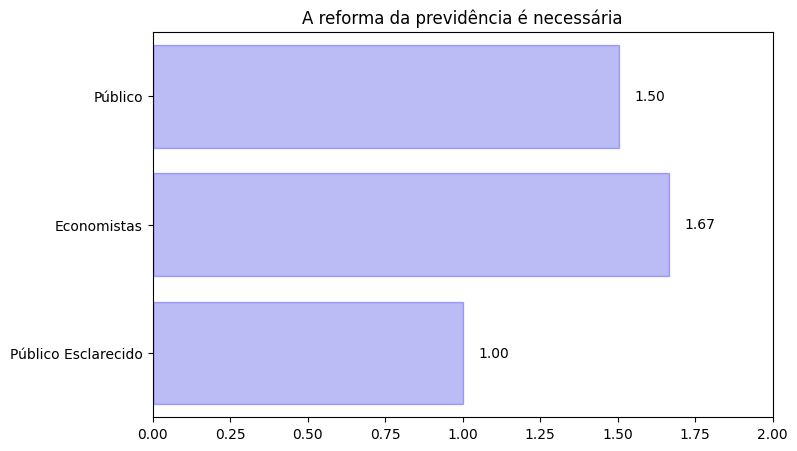

In [95]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
import textwrap

def analisar_variavel_para_latex(df, variavel):
    
    controle = [
        'nivel_formacao_economia',
        'econ',
        'masculino',
        'raca',
        'escolaridade',
        'faixa_etaria',
        'regiao',
        'vinculo_emprego',
        'trabalha_area_economia',
        'trabalha_area_politica',
        'engajamento_politico',
        'acompanha_noticias',
        'espectro_politico'
        ]
    
    print(f"Iniciando análise da variável '{variavel}'")
    
    # Preparando os dados
    df_var = df[[variavel] + controle].copy()
    df_var.dropna(inplace=True)
    
    # Convertendo tudo para numérico
    df_var = df_var.apply(pd.to_numeric)
    
    # Definindo variáveis dependente (target) e independentes
    X = df_var[controle]
    y = df_var[variavel]
    
    # Criando o modelo logit ordenado
    model = OrderedModel(y, X, distr='logit', hasconst=False)  # ou 'probit'
    result = model.fit(method='lbfgs')
    
    # Exibindo os resultados do modelo
    print(result.summary())
    
    # Filtrando o público esclarecido
    publico_esclarecido = df_var[df_var['econ'] == 1].copy()  # Evitando SettingWithCopyWarning
    publico_esclarecido['econ'] = 0  # Alterando a variável 'econ' para 0
    
    # Fazendo predições
    new_data = publico_esclarecido[controle]
    predictions = result.predict(new_data)
    
    # Calculando a média das predições
    y_pred = np.argmax(predictions, axis=1)  # Índice da maior probabilidade para cada linha
    mean_pred = y_pred.mean()
    
    # Cálculos de médias
    media_economistas = df_var[df_var['econ'] == 1][variavel].mean()
    media_publico_geral = df_var[df_var['econ'] == 0][variavel].mean()
    media_publico_esclarecido = mean_pred
    
    print(f'Média do público geral: {media_publico_geral}')
    print(f'Média dos economistas: {media_economistas}')
    print(f'Média do público esclarecido: {media_publico_esclarecido}')
    
    # Dados
    labels = ['Público', 'Economistas', 'Público Esclarecido']
    medias = [media_publico_geral, media_economistas, media_publico_esclarecido]
    
    # Usando aquele dicionário de perguntas para o título
    perguntas_titulo = rename_dict
    
    # Ajustando o tamanho do gráfico
    plt.figure(figsize=(8, 5))  # Largura fixa

    # Quebrando o título automaticamente para não estourar a largura da imagem
    titulo = textwrap.fill(perguntas_titulo.get(variavel), width=60)
    plt.title(titulo, wrap=True)

    # Criando o gráfico
    sns.barplot(x=medias, y=labels, color='blue', alpha=0.3, edgecolor='blue', linewidth=1)

    # Ajustes do gráfico
    plt.xlabel('')
    plt.ylabel('')
    plt.xlim(0, 2)  # Mantém a escala fixa no eixo X

    # Adicionando os valores nas barras
    for i, v in enumerate(medias):
        plt.text(v + 0.05, i, f'{v:.2f}', color='black', va='center')

    # Salvando a imagem
    plt.savefig(f'imagens/{variavel}.png', bbox_inches='tight')

    # Exibir o gráfico
    plt.show()

analisar_variavel_para_latex(df_final, variavel_escolhida)